
# Stock Price Prediction (TCS)

**Objective:** Predict the **Close** price of TCS using historical market data.  
We will:
1. Import & install packages (incl. `yfinance`).
2. Download TCS data from Yahoo Finance using `yfinance`.
3. Clean & explore data (EDA).
4. Scale features using **Standardization (Z-score)** and **Min-Max Normalization**.
5. Create **bins** for the Close price (Low/Medium/High) for analysis.
6. Train a **Linear Regression** model (with standardized features) and optionally compare with Min-Max.
7. Evaluate performance and visualize results.
8. Summarize conclusions and next steps.

> **Note:** This notebook uses only **matplotlib** for charts (no seaborn), and avoids setting custom colors.



## 1) Setup & Imports
If `yfinance` is not installed, uncomment the install cell below and run it.


In [4]:

# If needed, uncomment to install (Colab/Jupyter with internet required)
!pip -q install yfinance scikit-learn pandas numpy matplotlib


In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import yfinance as yf

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')



## 2) Download TCS Data from Yahoo Finance (via `yfinance`)
We will fetch **TCS.NS** (Tata Consultancy Services on NSE) daily data for the last ~10 years.


In [109]:

# Download historical daily data for TCS on NSE
ticker = "TCS.NS"
df = yf.download(ticker, period="10y", interval="1d", auto_adjust=False, progress=False)

In [111]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,,
2015-09-01,"1,084.5083","1,268.7000","1,305.6000","1,265.0000","1,278.0000",2987602
2015-09-02,"1,107.7593","1,295.9000","1,310.2250","1,274.0000","1,279.8500",3765950
2015-09-03,"1,113.6573","1,302.8000","1,307.5000","1,288.1250","1,298.0500",2265074
2015-09-04,"1,088.8035","1,273.7250","1,307.4500","1,269.5750","1,305.7000",2426396
2015-09-07,"1,085.5129","1,269.8750","1,279.9750","1,266.3500","1,276.5000",1759184


In [113]:
# Directly rename columns
df = df.droplevel(0, axis=1).reset_index()
df.columns = ['Date','Adj_Close','Close','High','Low','Open','Volume']

df.tail()

,Date,Adj_Close,Close,High,Low,Open,Volume
2463,2025-08-26,"3,157.2000","3,157.2000","3,162.0000","3,120.0000","3,129.0000",5522097
2464,2025-08-27,"3,157.2000","3,157.2000","3,157.2000","3,157.2000","3,157.2000",0
2465,2025-08-28,"3,093.7000","3,093.7000","3,146.5000","3,086.5000","3,145.0000",3116051
2466,2025-08-29,"3,084.7000","3,084.7000","3,115.0000","3,077.2000","3,093.0000",2271789
2467,2025-09-01,"3,112.6001","3,112.6001","3,131.1001","3,090.0000","3,090.0000",1246252



## 3) Basic Cleaning
- Convert `Date` to datetime (already handled by yfinance, but we ensure).
- Drop missing values (if any).
- Quick summary.


In [116]:

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop any rows with NaNs in key columns
df = df.dropna(subset=['Open','High','Low','Close','Volume'])

# Sort by Date just in case
df = df.sort_values('Date').reset_index(drop=True)

print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2468 non-null   datetime64[ns]
 1   Adj_Close  2468 non-null   float64       
 2   Close      2468 non-null   float64       
 3   High       2468 non-null   float64       
 4   Low        2468 non-null   float64       
 5   Open       2468 non-null   float64       
 6   Volume     2468 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 135.1 KB
None


,Date,Adj_Close,Close,High,Low,Open,Volume
count,2468,"2,468.0000","2,468.0000","2,468.0000","2,468.0000","2,468.0000","2,468.0000"
mean,2020-09-03 20:49:12.350081024,"2,412.4654","2,561.8366","2,587.1966","2,537.2694","2,562.7663","2,680,807.7435"
min,2015-09-01 00:00:00,916.3578,"1,050.5750","1,070.0000","1,025.9500","1,058.4500",0.0000
25%,2018-03-05 18:00:00,"1,333.4967","1,495.7437","1,515.0750","1,476.7625","1,488.6125","1,652,348.5000"
50%,2020-09-07 12:00:00,"2,164.1318","2,327.3500","2,353.2500","2,294.8000","2,321.5000","2,239,120.0000"
75%,2023-02-28 06:00:00,"3,307.8191","3,436.9125","3,460.2000","3,407.2000","3,434.0000","3,093,796.0000"
max,2025-09-01 00:00:00,"4,476.7495","4,553.7500","4,592.2500","4,512.0000","4,576.0000","88,067,154.0000"
std,NaN,"1,045.7661","1,024.9069","1,033.5064","1,017.2151","1,025.3777","2,389,260.9666"


In [118]:
missing_data = df.isnull()
missing_data

,Date,Adj_Close,Close,High,Low,Open,Volume
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
2463,False,False,False,False,False,False,False
2464,False,False,False,False,False,False,False
2465,False,False,False,False,False,False,False
2466,False,False,False,False,False,False,False


In [120]:
for column in missing_data.columns.values.tolist():
    print(missing_data[column].value_counts())
    print("")

Date
False    2468
Name: count, dtype: int64

Adj_Close
False    2468
Name: count, dtype: int64

Close
False    2468
Name: count, dtype: int64

High
False    2468
Name: count, dtype: int64

Low
False    2468
Name: count, dtype: int64

Open
False    2468
Name: count, dtype: int64

Volume
False    2468
Name: count, dtype: int64



In [122]:
df.dtypes

Date         datetime64[ns]
Adj_Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume                int64
dtype: object


## 4) Exploratory Data Analysis (EDA)
We'll look at the closing price trend and simple relationships.


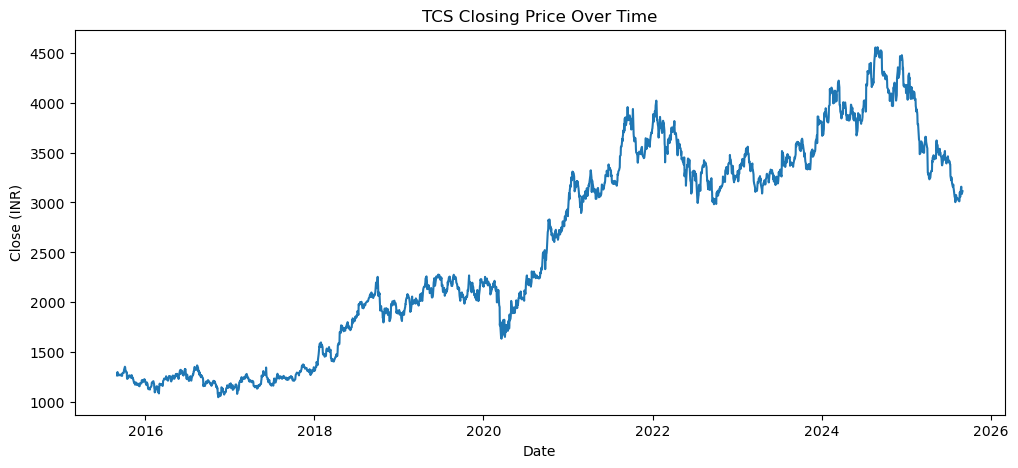

In [125]:

# Closing price over time
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'])
plt.title("TCS Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close (INR)")
plt.show()

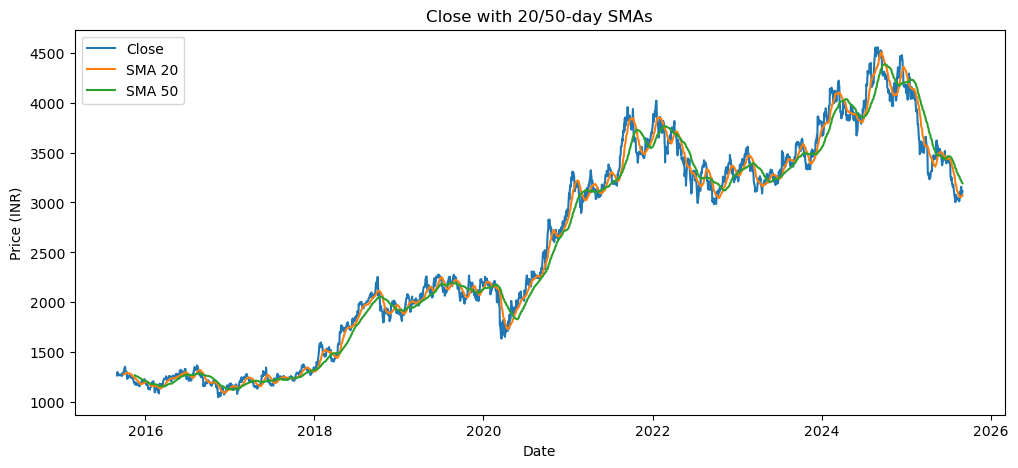

In [126]:

# Optional: Simple moving averages for context
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label="Close")
plt.plot(df['Date'], df['SMA_20'], label="SMA 20")
plt.plot(df['Date'], df['SMA_50'], label="SMA 50")
plt.title("Close with 20/50-day SMAs")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()


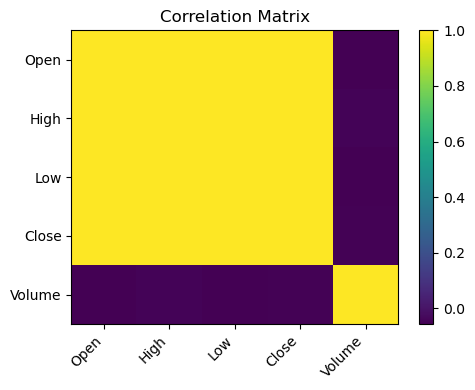

,Open,High,Low,Close,Volume
Open,1.0000,0.9997,0.9997,0.9994,-0.0522
High,0.9997,1.0000,0.9997,0.9998,-0.0465
Low,0.9997,0.9997,1.0000,0.9998,-0.0557
Close,0.9994,0.9998,0.9998,1.0000,-0.0510
Volume,-0.0522,-0.0465,-0.0557,-0.0510,1.0000


In [128]:

# Correlation matrix for numeric columns
features_for_corr = df[['Open','High','Low','Close','Volume']].copy()
corr = features_for_corr.corr(numeric_only=True)

plt.figure(figsize=(5,4))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.title("Correlation Matrix")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha='right')
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

corr



## 5) Feature Selection
We'll predict **Close** using features: **Open, High, Low, Volume**.


In [131]:

data = df[['Open','High','Low','Volume','Close']].dropna().copy()

X_raw = data[['Open','High','Low','Volume']].values
y = data['Close'].values



## 6) Scaling
We will create two scaled versions of the features:
- **Standardization (Z-score):** mean=0, std=1
- **Min-Max Normalization:** scaled to [0, 1]


In [135]:

# Standardization
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_raw)

# Min-Max Normalization
mm_scaler = MinMaxScaler()
X_mm = mm_scaler.fit_transform(X_raw)

# Show a quick preview
pd.DataFrame(X_std, columns=['Open','High','Low','Volume']).head()


,Open,High,Low,Volume
0,-1.2532,-1.2403,-1.2510,0.1284
1,-1.2514,-1.2358,-1.2421,0.4543
2,-1.2337,-1.2385,-1.2283,-0.1740
3,-1.2262,-1.2385,-1.2465,-0.1065
4,-1.2547,-1.2651,-1.2497,-0.3858


In [137]:

pd.DataFrame(X_mm, columns=['Open','High','Low','Volume']).head()


,Open,High,Low,Volume
0,0.0624,0.0669,0.0686,0.0339
1,0.0629,0.0682,0.0712,0.0428
2,0.0681,0.0674,0.0752,0.0257
3,0.0703,0.0674,0.0699,0.0276
4,0.0620,0.0596,0.0690,0.0200



## 8) Train–Test Split
We'll split the dataset into train and test sets. We'll first train using **Standardized** features, then optionally compare with **Min-Max**.


In [140]:

X_train_std, X_test_std, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42, shuffle=True
)

X_train_mm, X_test_mm, _, _ = train_test_split(
    X_mm, y, test_size=0.2, random_state=42, shuffle=True
)

len(X_train_std), len(X_test_std)

(1974, 494)


## 9) Model Training — Linear Regression (with Standardized Features)


In [143]:

lin_std = LinearRegression()
lin_std.fit(X_train_std, y_train)

y_pred_std = lin_std.predict(X_test_std)

mse_std = mean_squared_error(y_test, y_pred_std)
rmse_std = np.sqrt(mse_std)
mae_std = mean_absolute_error(y_test, y_pred_std)
r2_std = r2_score(y_test, y_pred_std)

print("=== Linear Regression (Standardized) ===")
print(f"MSE  : {mse_std:,.4f}")
print(f"RMSE : {rmse_std:,.4f}")
print(f"MAE  : {mae_std:,.4f}")
print(f"R^2  : {r2_std:,.4f}")


=== Linear Regression (Standardized) ===
MSE  : 199.3923
RMSE : 14.1206
MAE  : 10.3896
R^2  : 0.9998


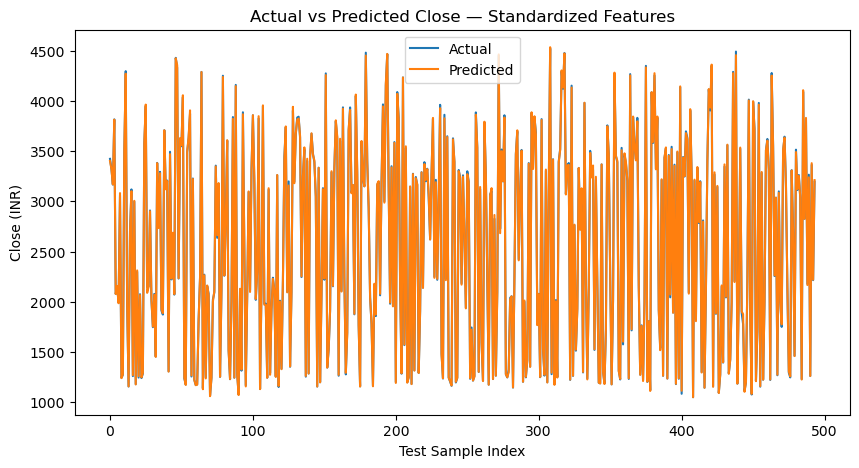

In [145]:

# Visualization — Actual vs Predicted (Standardized)
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(y_test)), y_pred_std, label="Predicted")
plt.title("Actual vs Predicted Close — Standardized Features")
plt.xlabel("Test Sample Index")
plt.ylabel("Close (INR)")
plt.legend()
plt.show()


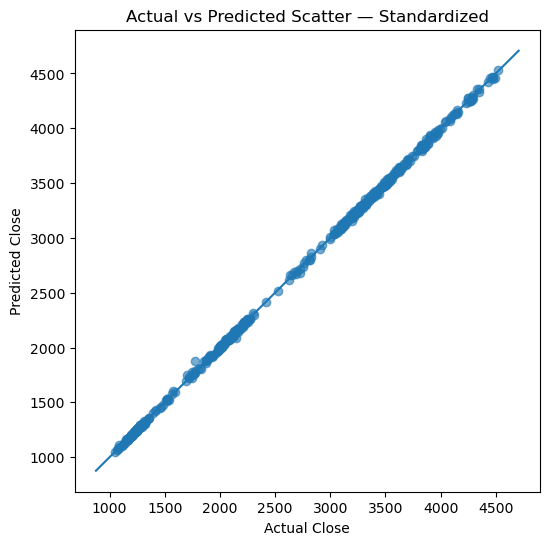

In [146]:

# Scatter plot — Actual vs Predicted (Standardized)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_std, alpha=0.6)
plt.title("Actual vs Predicted Scatter — Standardized")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
# 45-degree reference line
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims)
plt.show()


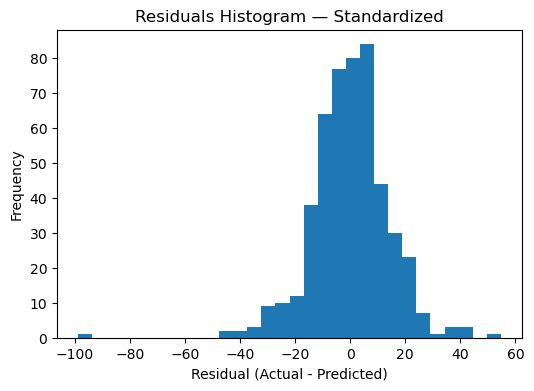

In [148]:

# Residuals histogram — Standardized
resid_std = y_test - y_pred_std
plt.figure(figsize=(6,4))
plt.hist(resid_std, bins=30)
plt.title("Residuals Histogram — Standardized")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()



## 10) (Optional) Compare with Min‑Max Scaled Features


In [151]:

lin_mm = LinearRegression()
lin_mm.fit(X_train_mm, y_train)

y_pred_mm = lin_mm.predict(X_test_mm)

mse_mm = mean_squared_error(y_test, y_pred_mm)
rmse_mm = np.sqrt(mse_mm)
mae_mm = mean_absolute_error(y_test, y_pred_mm)
r2_mm = r2_score(y_test, y_pred_mm)

print("=== Linear Regression (Min-Max) ===")
print(f"MSE  : {mse_mm:,.4f}")
print(f"RMSE : {rmse_mm:,.4f}")
print(f"MAE  : {mae_mm:,.4f}")
print(f"R^2  : {r2_mm:,.4f}")


=== Linear Regression (Min-Max) ===
MSE  : 199.3923
RMSE : 14.1206
MAE  : 10.3896
R^2  : 0.9998


In [154]:

# Side-by-side metric comparison
metrics = pd.DataFrame({
    'Metric': ['MSE','RMSE','MAE','R^2'],
    'Standardized': [mse_std, np.sqrt(mse_std), mae_std, r2_std],
    'MinMax': [mse_mm, np.sqrt(mse_mm), mae_mm, r2_mm]
})
metrics


,Metric,Standardized,MinMax
0,MSE,199.3923,199.3923
1,RMSE,14.1206,14.1206
2,MAE,10.3896,10.3896
3,R^2,0.9998,0.9998



## 11) Conclusions & Next Steps

**What we did**
- Pulled **TCS.NS** data from Yahoo Finance with `yfinance`.
- Cleaned data and explored trends (Close over time, SMAs, correlations).
- Scaled features with **Standardization** and **Min-Max**.
- Trained and evaluated **Linear Regression** using both scaled feature sets.
- Visualized actual vs predicted, scatter, and residuals.